# create curves

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline

def generate_control_points_in_vertical_sections(num_points, plane_width, plane_height):
    """
    Divide the plane into vertical sections and generate one random control point per section.

    Args:
        num_points (int): Number of control points (and vertical sections).
        plane_width (float): Width of the plane.
        plane_height (float): Height of the plane.

    Returns:
        control_points (list of tuples): Each tuple is (x, y).
        section_bounds (list of tuples): Each tuple is (x_min, x_max) for a section.
    """
    section_width = plane_width / num_points
    control_points = []
    section_bounds = []
    for i in range(num_points):
        x_min = i * section_width
        x_max = (i + 1) * section_width
        section_bounds.append((x_min, x_max))
        # Generate a random control point within the section.
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(0, plane_height)
        control_points.append((x, y))
    return control_points, section_bounds

def create_bspline_curve(control_points, closed=False):
    """
    Create a cubic B-spline curve from control points.

    Args:
        control_points (list of tuples): List of (x, y) coordinates.
        closed (bool): If True, the curve is closed (the first k points are repeated).

    Returns:
        bspline (tuple): A tuple (spline_x, spline_y) where each is a BSpline object.
    """
    # Extract x and y coordinates.
    x = np.array([pt[0] for pt in control_points])
    y = np.array([pt[1] for pt in control_points])
    k = 3  # Cubic B-spline

    if closed:
        # To close the curve, repeat the first k control points.
        x = np.concatenate((x, x[:k]))
        y = np.concatenate((y, y[:k]))
        n_knots = len(x) + k + 1
        knots = np.linspace(0, 1, n_knots)
    else:
        n_knots = len(x) + k + 1
        knots = np.concatenate((
            np.zeros(k),
            np.linspace(0, 1, len(x) - k + 1),
            np.ones(k)
        ))

    spline_x = BSpline(knots, x, k, extrapolate=False)
    spline_y = BSpline(knots, y, k, extrapolate=False)
    return (spline_x, spline_y)

def create_test_data_vertical_sections(num_curves, num_points, plane_width, plane_height, closed=False):
    """
    Generate test data consisting of multiple B-spline curves (as BSpline objects)
    created using vertical sections.

    Each data entry is a tuple:
        (control_points, bspline, section_bounds)
    where bspline is a tuple (spline_x, spline_y).

    Args:
        num_curves (int): Total number of curves to generate.
        num_points (int): Number of control points per curve.
        plane_width (float): Width of the plane.
        plane_height (float): Height of the plane.
        closed (bool): If True, generate closed curves.

    Returns:
        data (list): List of tuples (control_points, bspline, section_bounds).
    """
    data = []
    for _ in range(num_curves):
        control_points, section_bounds = generate_control_points_in_vertical_sections(num_points, plane_width, plane_height)
        bspline = create_bspline_curve(control_points, closed=closed)
        data.append((control_points, bspline, section_bounds))
    return data

def visualize_curve(control_points, bspline, section_bounds, num_samples=161):
    """
    Visualize a B-spline curve (for display) along with its control points and vertical sections.

    Note: Although the BSpline is stored as a callable object (tuple of BSpline objects), we sample
    it here only for visualization purposes.

    Args:
        control_points (list): List of (x, y) control point tuples.
        bspline (tuple): A tuple (spline_x, spline_y) of BSpline objects.
        section_bounds (list): List of (x_min, x_max) tuples for vertical sections.
        num_samples (int): Number of points to sample for visualization.
    """
    spline_x, spline_y = bspline
    # Determine the valid parameter range from the BSpline knot vector.
    t_min = spline_x.t[spline_x.k]
    t_max = spline_x.t[-spline_x.k-1]
    t_vals = np.linspace(t_min, t_max, num_samples)
    curve_x = spline_x(t_vals)
    curve_y = spline_y(t_vals)
    curve_points = np.column_stack((curve_x, curve_y))

    # Convert control points to an array.
    control_points_arr = np.array(control_points)

    plt.figure(figsize=(10, 6))
    # Plot the B-spline curve.
    plt.plot(curve_points[:, 0], curve_points[:, 1], label="B-Spline Curve", color='blue')
    # Plot control points and polygon.
    plt.scatter(control_points_arr[:, 0], control_points_arr[:, 1], color='red', label="Control Points", zorder=5)
    plt.plot(control_points_arr[:, 0], control_points_arr[:, 1], 'r--', alpha=0.5)

    # Plot vertical section boundaries.
    for idx, (x_min, x_max) in enumerate(section_bounds):
        label = "Section Bounds" if idx == 0 else None
        plt.axvline(x=x_min, color='green', linestyle='--', label=label)
        plt.axvline(x=x_max, color='green', linestyle='--')

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("B-Spline Curve with Control Points and Vertical Sections")
    plt.legend()
    plt.grid(True)
    plt.show()


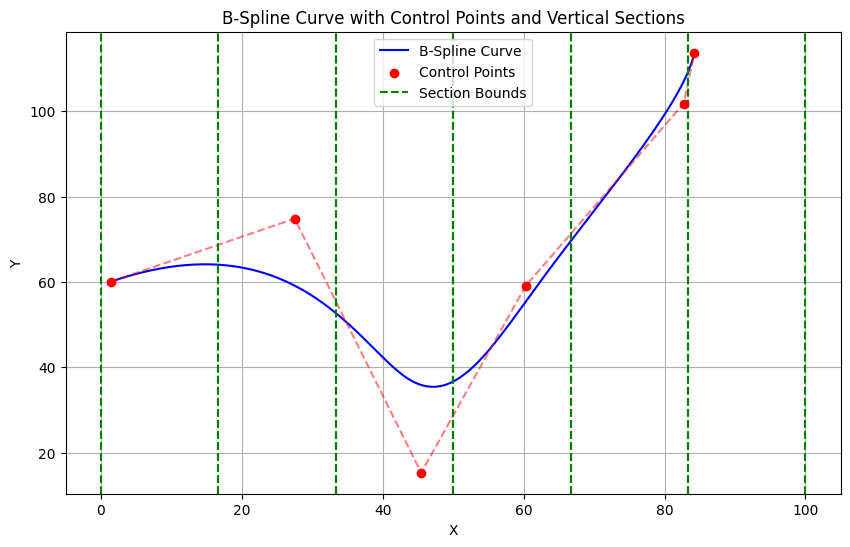

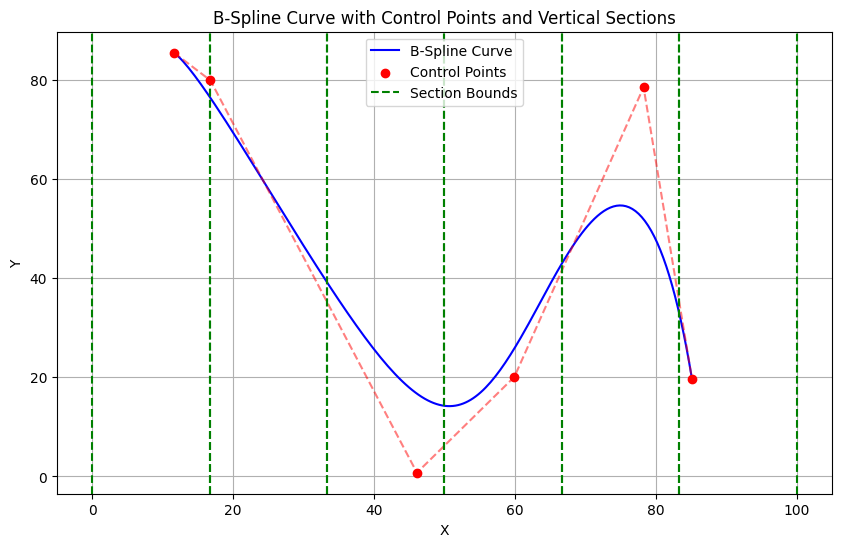

In [43]:
# Parameters for test data.
num_curves = 100      # Total number of curves to generate.
num_points = 6        # Number of control points per curve.
plane_width = 100     # Width of the 2D plane.
plane_height = 120    # Height of the 2D plane.
closed = False        # Whether the curves are closed.

# Generate test data (each entry contains control points, a BSpline, and section bounds).
test_data_vertical_sections = create_test_data_vertical_sections(
    num_curves, num_points, plane_width, plane_height, closed=closed
)

# Visualize two example curves from the test data.
curve6 = test_data_vertical_sections[6]  # tuple: (control_points, bspline, section_bounds)
curve8 = test_data_vertical_sections[8]

visualize_curve(curve6[0], curve6[1], curve6[2])
visualize_curve(curve8[0], curve8[1], curve8[2])


# place in 3D

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
# For 3D plotting, we use matplotlib's 3D projection.
# (No need to explicitly import Axes3D in recent versions of matplotlib.)

def wrap_bspline_in_3d(bspline, z):
    """
    Given a 2D BSpline (a tuple of (spline_x, spline_y)) and a constant z,
    return a function that evaluates the BSpline and appends the constant z.
    Also returns the valid parameter domain (t_min, t_max).
    """
    spline_x, spline_y = bspline
    # Valid parameter domain from the underlying BSpline.
    t_min = spline_x.t[spline_x.k]
    t_max = spline_x.t[-spline_x.k-1]
    def bspline_3d(t):
        # t can be scalar or array-like.
        x = spline_x(t)
        y = spline_y(t)
        # Ensure z is broadcasted to the same shape as x.
        z_arr = np.full(np.shape(x), z)
        return np.column_stack((x, y, z_arr))
    return bspline_3d, t_min, t_max

def place_curves_in_z(curve1, curve2, z_gap=None):
    """
    Takes two curves (each as a tuple: (control_points, bspline, section_bounds))
    and places them in 3D so that one is at z = 0 and the other at z = z_gap.

    If z_gap is not provided, a random gap between 40 and 100 is chosen.

    Returns:
        new_curve1, new_curve2, z_gap
    where each new_curve is a tuple:
        (control_points_3d, bspline_3d, section_bounds, t_min, t_max, z)
    """
    if z_gap is None:
        z_gap = np.random.uniform(40, 100)

    # Unpack curves.
    control_points1, bspline1, section_bounds1 = curve1
    control_points2, bspline2, section_bounds2 = curve2

    # Convert 2D control points into 3D by appending a constant z.
    cp1_3d = [ (x, y, 0) for (x, y) in control_points1 ]
    cp2_3d = [ (x, y, z_gap) for (x, y) in control_points2 ]

    # Wrap the 2D BSpline into a 3D function.
    bspline1_3d, tmin1, tmax1 = wrap_bspline_in_3d(bspline1, 0)
    bspline2_3d, tmin2, tmax2 = wrap_bspline_in_3d(bspline2, z_gap)

    new_curve1 = (cp1_3d, bspline1_3d, section_bounds1, tmin1, tmax1, 0)
    new_curve2 = (cp2_3d, bspline2_3d, section_bounds2, tmin2, tmax2, z_gap)

    return new_curve1, new_curve2, z_gap

def visualize_curves_3d(curve1_3d, curve2_3d, plane_width, plane_height, num_samples=161):
    """
    Visualize two 3D curves (with their control points and vertical section boundaries)
    in a 3D plot.

    Each curve is expected as a tuple:
        (control_points_3d, bspline_3d, section_bounds, t_min, t_max, z)
    The section_bounds are given as (x_min, x_max) and are drawn at the curve's z level,
    with y spanning from 0 to plane_height.

    Args:
        curve1_3d, curve2_3d: Data for the two curves.
        plane_width (float): Used to set x-axis limits.
        plane_height (float): Used to set y-axis limits.
        num_samples (int): Number of points to sample for each BSpline.
    """
    # Unpack curve 1.
    cp1, bspline1_3d, sec_bounds1, tmin1, tmax1, z1 = curve1_3d
    # Unpack curve 2.
    cp2, bspline2_3d, sec_bounds2, tmin2, tmax2, z2 = curve2_3d

    # Sample both curves.
    t_vals1 = np.linspace(tmin1, tmax1, num_samples)
    curve1_points = bspline1_3d(t_vals1)

    t_vals2 = np.linspace(tmin2, tmax2, num_samples)
    curve2_points = bspline2_3d(t_vals2)

    # Prepare 3D figure.
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot curve 1.
    ax.plot(curve1_points[:, 0], curve1_points[:, 1], curve1_points[:, 2],
            label="Curve 1 (z = 0)", color='blue')
    cp1_arr = np.array(cp1)
    ax.scatter(cp1_arr[:, 0], cp1_arr[:, 1], cp1_arr[:, 2],
               color='red', label="Curve 1 Control Points", s=50)

    # Draw vertical section boundaries for curve 1 at z1.
    for (x_min, x_max) in sec_bounds1:
        # Draw two vertical lines (at x_min and x_max) spanning y from 0 to plane_height.
        ax.plot([x_min, x_min], [0, plane_height], [z1, z1],
                linestyle='--', color='green')
        ax.plot([x_max, x_max], [0, plane_height], [z1, z1],
                linestyle='--', color='green')

    # Plot curve 2.
    ax.plot(curve2_points[:, 0], curve2_points[:, 1], curve2_points[:, 2],
            label=f"Curve 2 (z = {z2:.1f})", color='magenta')
    cp2_arr = np.array(cp2)
    ax.scatter(cp2_arr[:, 0], cp2_arr[:, 1], cp2_arr[:, 2],
               color='orange', label="Curve 2 Control Points", s=50)

    # Draw vertical section boundaries for curve 2 at z2.
    for (x_min, x_max) in sec_bounds2:
        ax.plot([x_min, x_min], [0, plane_height], [z2, z2],
                linestyle='--', color='green')
        ax.plot([x_max, x_max], [0, plane_height], [z2, z2],
                linestyle='--', color='green')

    # Set labels and title.
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Curves with Control Point Mesh and Vertical Sections")
    ax.legend()

    # Set axis limits.
    ax.set_xlim(0, plane_width)
    ax.set_ylim(0, plane_height)
    # The z-axis limit is automatically adjusted.
    plt.show()


Placed curve 2 at z = 0 and curve 2 at z = 83.65


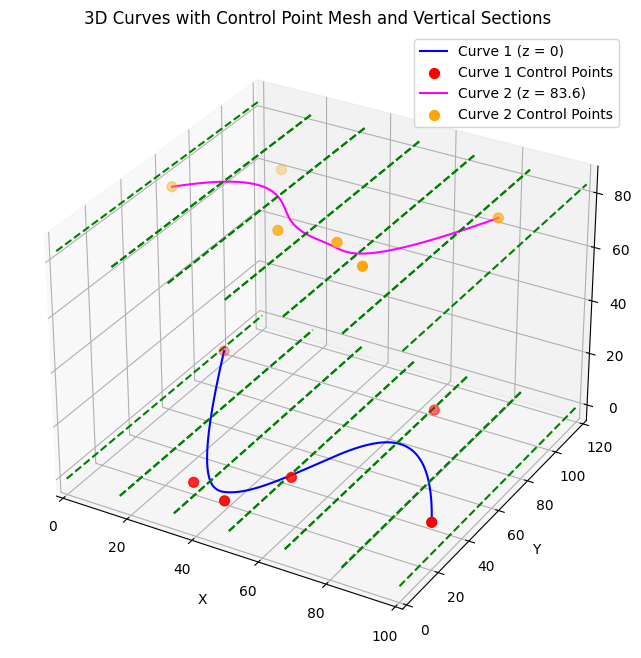

In [45]:
# Parameters for 2D test data.
num_curves = 100
num_points = 6
plane_width = 100
plane_height = 120
closed = False

# Generate 2D test data.
test_data = create_test_data_vertical_sections(num_curves, num_points, plane_width, plane_height, closed=closed)

# Take two curves (for example, the ones at indices 6 and 8).
curve2d_1 = test_data[6]  # (control_points, bspline, section_bounds)
curve2d_2 = test_data[8]

# Place them in 3D. Curve 1 will be at z = 0; curve 2 will be lifted by a gap between 40 and 100.
curve3d_1, curve3d_2, gap = place_curves_in_z(curve2d_1, curve2d_2)
print(f"Placed curve 2 at z = 0 and curve 2 at z = {gap:.2f}")

# Visualize the 3D curves with their control point meshes and vertical section boundaries.
visualize_curves_3d(curve3d_1, curve3d_2, plane_width, plane_height, num_samples=161)

interpolate_surface_between_curves
This function takes two 3D curves (each produced by “lifting” a 2D BSpline into 3D via our previous functions) and linearly interpolates between them. For each of a set of parameter values along the curve (u) and for each interpolation weight (v) in [0,1], it computes

𝑆
(
𝑢
,
𝑣
)
=
(
1
−
𝑣
)
 
𝑃
1
(
𝑢
)
+
𝑣
 
𝑃
2
(
𝑢
)
S(u,v)=(1−v)P
1
​
 (u)+vP
2
​
 (u)
returning a mesh of surface points.

visualize_surface_3d
This function displays the interpolated surface in 3D (using plot_surface) and—if desired—overlays the two original curves and their control point meshes.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Not required in newer versions, but added for clarity.
from matplotlib import cm

def interpolate_surface_between_curves(curve1_3d, curve2_3d, num_u=161, num_v=20):
    """
    Interpolate between two 3D curves to create a surface.

    Each curve is a tuple:
      (control_points_3d, bspline_3d, section_bounds, t_min, t_max, z)
    where bspline_3d is a callable that takes a parameter t and returns a 3D point.

    The function samples both curves at num_u points along their parameter domain
    and then linearly interpolates between them using num_v steps.

    Args:
        curve1_3d: First 3D curve tuple.
        curve2_3d: Second 3D curve tuple.
        num_u (int): Number of sample points along the curve.
        num_v (int): Number of interpolation steps between curves.

    Returns:
        surface_points (np.ndarray): Array of shape (num_v, num_u, 3) representing the surface.
    """
    # Unpack curves.
    _, bspline1_3d, _, tmin1, tmax1, _ = curve1_3d
    _, bspline2_3d, _, tmin2, tmax2, _ = curve2_3d

    # For simplicity, we assume both curves have the same valid parameter range.
    # (If not, you might want to use the intersection or rescale accordingly.)
    t_vals = np.linspace(tmin1, tmax1, num_u)
    points1 = bspline1_3d(t_vals)  # Shape: (num_u, 3)
    points2 = bspline2_3d(t_vals)  # Shape: (num_u, 3)

    # Create an interpolation weight v in [0,1].
    v_vals = np.linspace(0, 1, num_v)
    # Initialize surface mesh array.
    surface_points = np.empty((num_v, num_u, 3))

    # For each interpolation step, compute S(u,v) = (1-v)*P1(u) + v*P2(u)
    for i, v in enumerate(v_vals):
        surface_points[i,:,:] = (1 - v) * points1 + v * points2

    return surface_points

def visualize_surface_3d(surface_points, curve1_3d=None, curve2_3d=None, show_control_points=False):
    """
    Visualize a surface (and optionally overlay the two 3D curves and their control points) in 3D.

    Args:
        surface_points (np.ndarray): Array of shape (num_v, num_u, 3) representing the surface.
        curve1_3d: (Optional) First 3D curve tuple: (control_points_3d, bspline_3d, section_bounds, t_min, t_max, z).
        curve2_3d: (Optional) Second 3D curve tuple.
        show_control_points (bool): If True and curve data is provided, overlay control point meshes.
    """
    num_v, num_u, _ = surface_points.shape
    # Create mesh grids for plotting the surface.
    X = surface_points[:, :, 0]
    Y = surface_points[:, :, 1]
    Z = surface_points[:, :, 2]

    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface using a colormap.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.7, edgecolor='none')
    fig.colorbar(surf, shrink=0.5, aspect=10, label='Surface height')

    # Optionally overlay the original curves.
    if curve1_3d is not None and curve2_3d is not None:
        # Unpack curves.
        cp1, bspline1_3d, _, tmin1, tmax1, z1 = curve1_3d
        cp2, bspline2_3d, _, tmin2, tmax2, z2 = curve2_3d

        # Sample each curve.
        t_vals1 = np.linspace(tmin1, tmax1, num_u)
        t_vals2 = np.linspace(tmin2, tmax2, num_u)
        curve1_points = bspline1_3d(t_vals1)
        curve2_points = bspline2_3d(t_vals2)

        ax.plot(curve1_points[:, 0], curve1_points[:, 1], curve1_points[:, 2],
                label=f"Curve 1 (z = {z1})", color='blue', linewidth=2)
        ax.plot(curve2_points[:, 0], curve2_points[:, 1], curve2_points[:, 2],
                label=f"Curve 2 (z = {z2})", color='magenta', linewidth=2)

        # Optionally plot control points.
        if show_control_points:
            cp1_arr = np.array(cp1)
            cp2_arr = np.array(cp2)
            ax.scatter(cp1_arr[:, 0], cp1_arr[:, 1], cp1_arr[:, 2],
                       color='red', s=50, label="Curve 1 Control Points")
            ax.scatter(cp2_arr[:, 0], cp2_arr[:, 1], cp2_arr[:, 2],
                       color='orange', s=50, label="Curve 2 Control Points")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Interpolated Surface Between Two 3D Curves")
    ax.legend()
    plt.show()


Placed curve 2 at z = 0 and curve 2 at z = 51.30


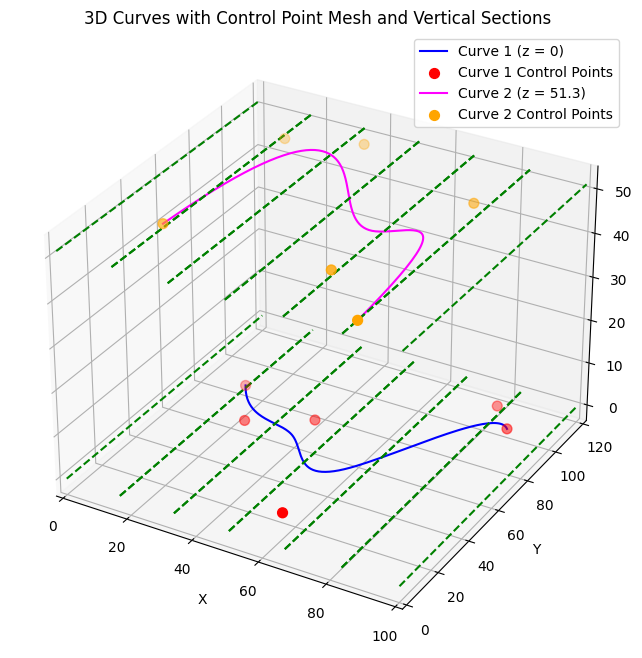

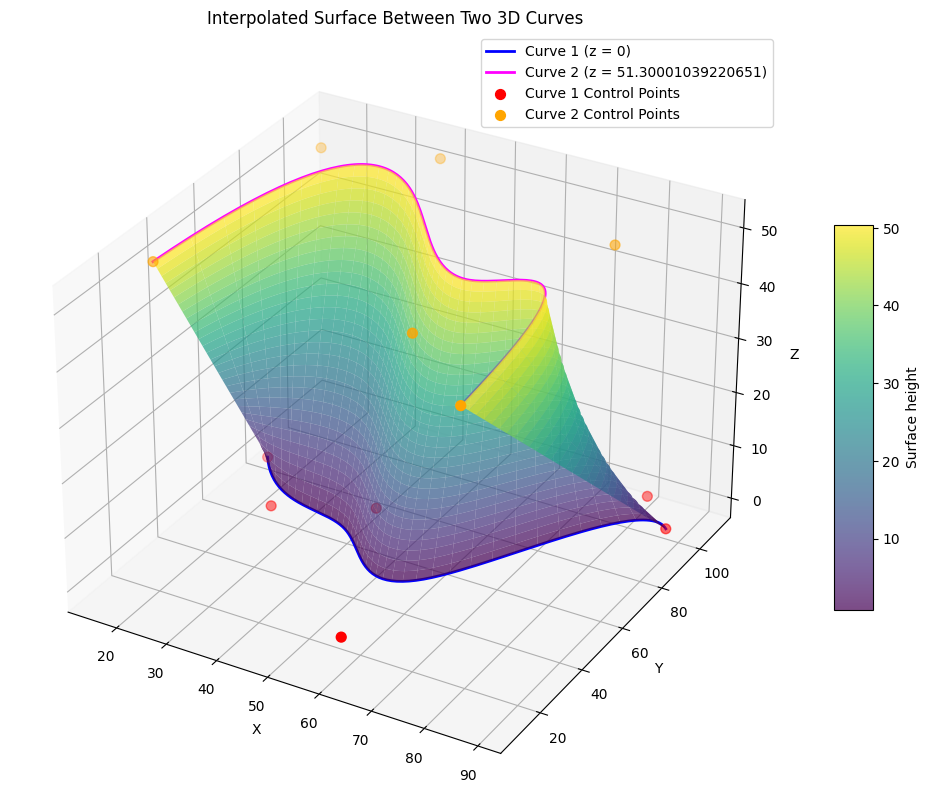

In [47]:
# Parameters for 2D test data.
num_curves = 100
num_points = 6
plane_width = 100
plane_height = 120
closed = False

# Generate 2D test data.
test_data = create_test_data_vertical_sections(num_curves, num_points, plane_width, plane_height, closed=closed)

# Take two curves (for example, the ones at indices 6 and 8).
curve2d_1 = test_data[6]  # (control_points, bspline, section_bounds)
curve2d_2 = test_data[8]

# Place them in 3D. Curve 1 will be at z = 0; curve 2 will be lifted by a gap between 40 and 100.
curve3d_1, curve3d_2, gap = place_curves_in_z(curve2d_1, curve2d_2)
print(f"Placed curve 2 at z = 0 and curve 2 at z = {gap:.2f}")

# Visualize the 3D curves with their control point meshes and vertical section boundaries.
visualize_curves_3d(curve3d_1, curve3d_2, plane_width, plane_height, num_samples=161)

# Interpolate a surface between the two 3D curves.
surface = interpolate_surface_between_curves(curve3d_1, curve3d_2, num_u=161, num_v=30)

# Visualize the resulting surface.
visualize_surface_3d(surface, curve1_3d=curve3d_1, curve2_3d=curve3d_2, show_control_points=True)

# more test data

Placed curve 1 at z = 0 and curve 2 at z = 55.32


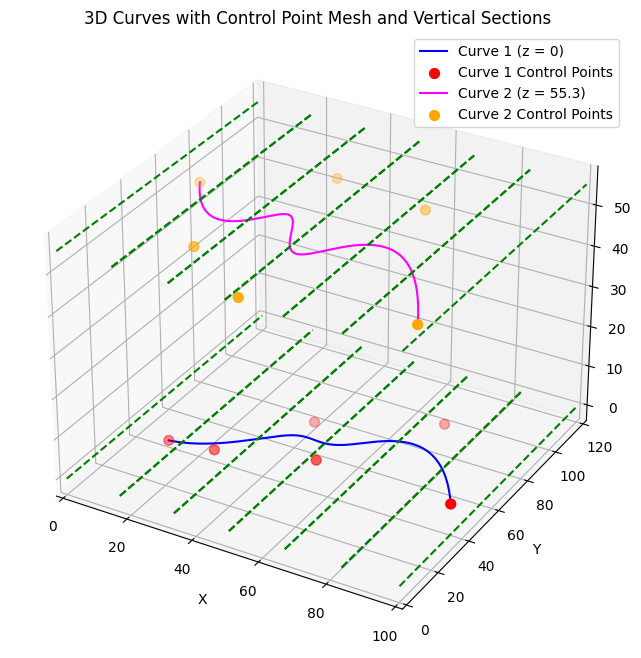

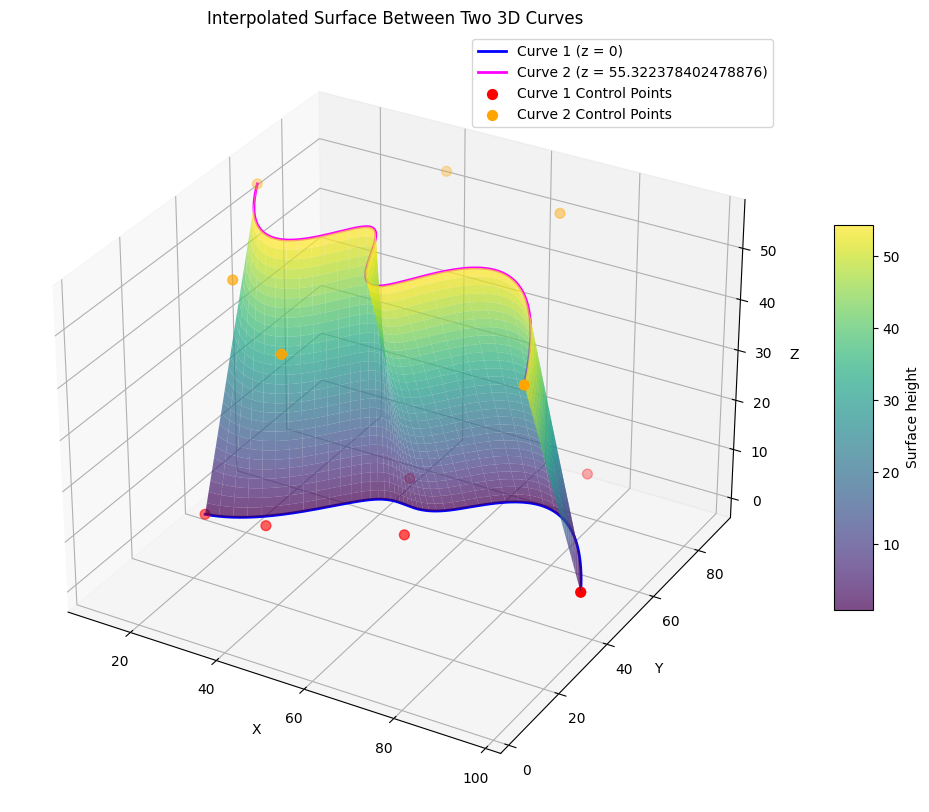

In [48]:
def show_off_new_data(num_curves=10, num_points=6, plane_width=100, plane_height=120,
                      closed=False, index1=6, index2=8, num_samples=161, num_v=30):
    """
    Generates 2D test data, selects two curves by index, places them in 3D (with one curve
    at z=0 and the other lifted by a gap between 40 and 100), visualizes the 3D curves with their
    control point meshes and vertical section boundaries, interpolates a surface between them,
    and then visualizes the surface.

    Args:
        num_curves (int): Number of curves to generate.
        num_points (int): Number of control points per curve.
        plane_width (float): Width of the 2D plane.
        plane_height (float): Height of the 2D plane.
        closed (bool): If True, generate closed curves.
        index1 (int): Index of the first curve to use.
        index2 (int): Index of the second curve to use.
        num_samples (int): Number of sample points for curve visualization.
        num_v (int): Number of interpolation steps between curves for the surface.
    """
    # Generate 2D test data.
    test_data = create_test_data_vertical_sections(num_curves, num_points, plane_width, plane_height, closed=closed)

    # Select two curves from the test data.
    curve2d_1 = test_data[index1]  # (control_points, bspline, section_bounds)
    curve2d_2 = test_data[index2]

    # Place the two 2D curves in 3D.
    curve3d_1, curve3d_2, gap = place_curves_in_z(curve2d_1, curve2d_2)
    print(f"Placed curve 1 at z = 0 and curve 2 at z = {gap:.2f}")

    # Visualize the 3D curves with their control point meshes and vertical section boundaries.
    visualize_curves_3d(curve3d_1, curve3d_2, plane_width, plane_height, num_samples=num_samples)

    # Interpolate a surface between the two 3D curves.
    surface = interpolate_surface_between_curves(curve3d_1, curve3d_2, num_u=num_samples, num_v=num_v)

    # Visualize the resulting surface, overlaying the original curves and (optionally) control points.
    visualize_surface_3d(surface, curve1_3d=curve3d_1, curve2_3d=curve3d_2, show_control_points=True)

# Example call: simply call the function to generate and display the new data.
show_off_new_data()


In [49]:
# --- New Functions for Approximating and Visualizing the Surface Control Net ---

def get_surface_control_net(surface_points, degree_u=3, degree_v=3, ctrlpts_size_u=10, ctrlpts_size_v=10):
    """
    Given a surface defined by a grid of points (an array of shape (num_v, num_u, 3)),
    approximate it with a NURBS surface using the geomdl library, and return the surface object.

    Args:
        surface_points (np.ndarray): Array of shape (num_v, num_u, 3) representing the surface.
        degree_u (int): Degree of the NURBS surface in the u-direction.
        degree_v (int): Degree of the NURBS surface in the v-direction.
        ctrlpts_size_u (int): Desired number of control points in the u-direction.
        ctrlpts_size_v (int): Desired number of control points in the v-direction.

    Returns:
        surf (geomdl.NURBS.Surface): The fitted NURBS surface.
    """
    from geomdl import fitting, NURBS

    # Get sample grid dimensions (note: our surface_points shape is (num_v, num_u, 3))
    num_v, num_u, _ = surface_points.shape
    # Flatten the grid to a list of points (row-major order)
    points_list = surface_points.reshape(-1, 3).tolist()

    # Use geomdl.fitting.approximate_surface to fit a NURBS surface to our data.
    # The sample sizes are given as (size_u, size_v), so we pass num_u, num_v.
    surf = fitting.approximate_surface(points_list,
                                       size_u=num_v,
                                       size_v=num_u,
                                       ctrlpts_size_u=ctrlpts_size_u,
                                       ctrlpts_size_v=ctrlpts_size_v,
                                       degree_u=degree_u,
                                       degree_v=degree_v)
    return surf

def visualize_surface_control_net(surf):
    """
    Visualize the control net (control point grid) of a geomdl NURBS surface.

    Args:
        surf (geomdl.NURBS.Surface): A NURBS surface object from geomdl.
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

    # Get control points as a flat list
    ctrlpts = surf.ctrlpts

    # Try to get grid dimensions; if ctrlpts_size is not iterable, use ctrlpts_size_u and ctrlpts_size_v
    try:
        size_u, size_v = surf.ctrlpts_size
    except TypeError:
        size_u = surf.ctrlpts_size_u
        size_v = surf.ctrlpts_size_v

    # Reshape control points into a 2D array of shape (size_u, size_v, 3)
    ctrlpts_array = np.array(ctrlpts).reshape((size_u, size_v, 3))

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the control points
    ax.scatter(ctrlpts_array[:,:,0], ctrlpts_array[:,:,1], ctrlpts_array[:,:,2],
               color='red', s=50, label="Control Points")

    # Connect control points along u direction
    for i in range(size_u):
        ax.plot(ctrlpts_array[i,:,0], ctrlpts_array[i,:,1], ctrlpts_array[i,:,2],
                color='blue', linestyle='--')

    # Connect control points along v direction
    for j in range(size_v):
        ax.plot(ctrlpts_array[:,j,0], ctrlpts_array[:,j,1], ctrlpts_array[:,j,2],
                color='blue', linestyle='--')

    ax.set_title("NURBS Surface Control Net")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()


Curve 1 is at z = 0 and Curve 2 is at z = 80.64


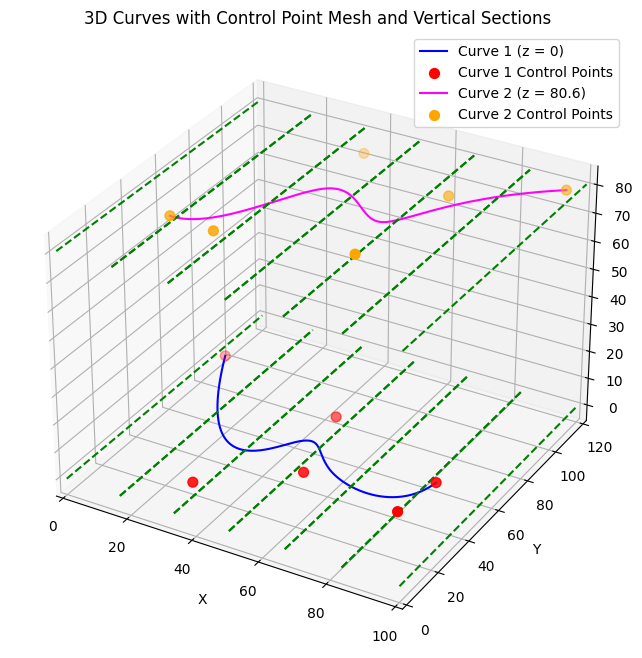

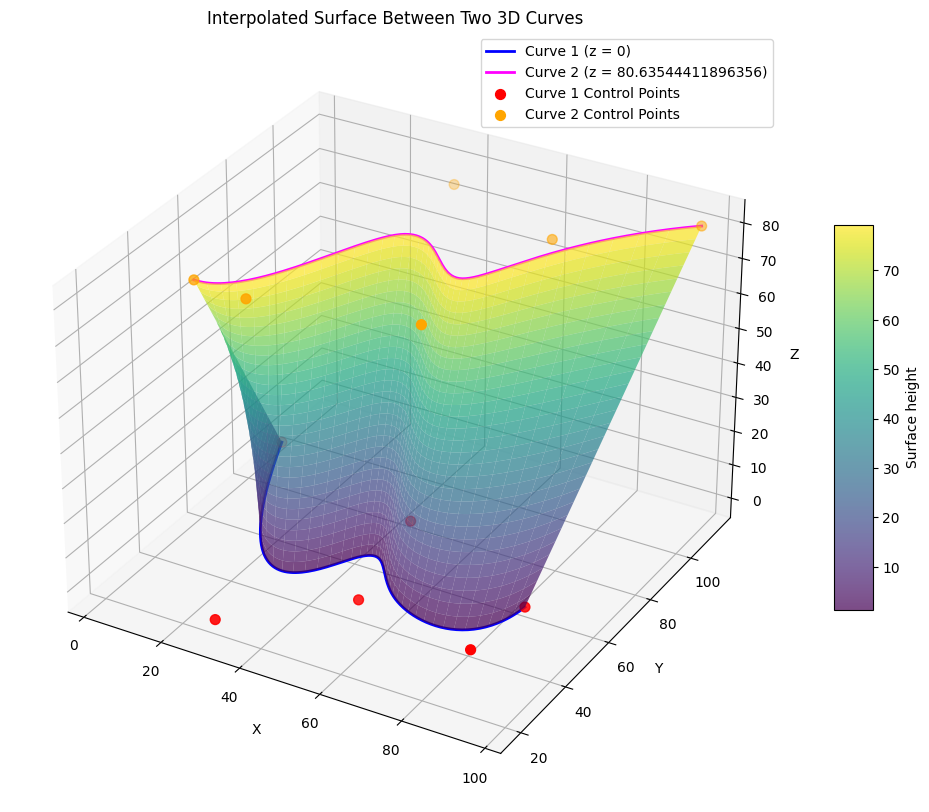

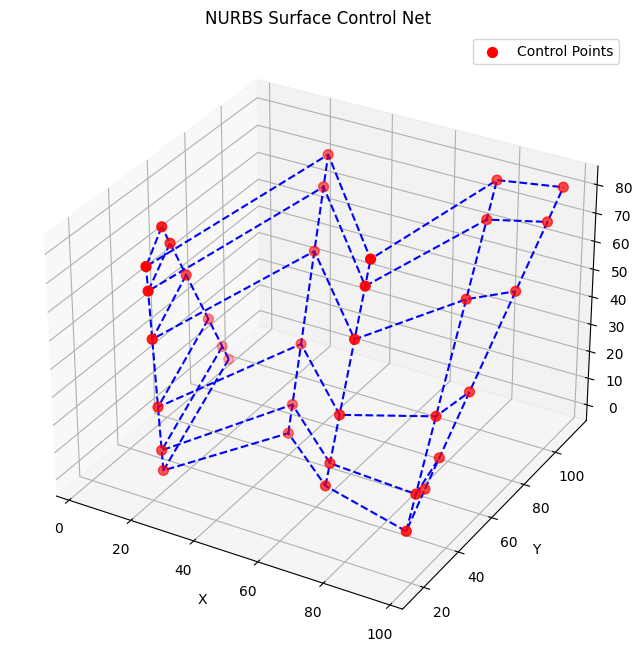

In [50]:
# --- Example: Generate, Interpolate, and Get the Surface Control Net ---

# Parameters for 2D curves.
num_curves = 100
num_points = 6
plane_width = 100
plane_height = 120
closed = False

# Generate 2D test data.
test_data = create_test_data_vertical_sections(num_curves, num_points, plane_width, plane_height, closed=closed)

# Select two curves (for example, indices 6 and 8).
curve2d_1 = test_data[6]  # (control_points, bspline, section_bounds)
curve2d_2 = test_data[8]

# Place the selected curves in 3D.
curve3d_1, curve3d_2, gap = place_curves_in_z(curve2d_1, curve2d_2)
print(f"Curve 1 is at z = 0 and Curve 2 is at z = {gap:.2f}")

# Visualize the 3D curves with control point meshes and vertical sections.
visualize_curves_3d(curve3d_1, curve3d_2, plane_width, plane_height, num_samples=161)

# Interpolate a surface between the two 3D curves.
surface_points = interpolate_surface_between_curves(curve3d_1, curve3d_2, num_u=161, num_v=30)

# Visualize the interpolated surface.
visualize_surface_3d(surface_points, curve1_3d=curve3d_1, curve2_3d=curve3d_2, show_control_points=True)

# --- Now use geomdl to approximate a NURBS surface from the interpolated data ---
# Adjust the desired control net sizes as needed.
nurbs_surf = get_surface_control_net(surface_points, degree_u=3, degree_v=3, ctrlpts_size_u=6, ctrlpts_size_v=6)

# Visualize the control net of the approximated NURBS surface.
visualize_surface_control_net(nurbs_surf)


# rebuild from control points

In [51]:
from geomdl import NURBS, utilities
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
from matplotlib import cm

def rebuild_nurbs_surface_from_control_net(old_surf):
    """
    Given a fitted NURBS surface (old_surf) with its control net,
    create a new NURBS surface using the same control points but with
    uniform knot vectors.

    Args:
        old_surf (geomdl.NURBS.Surface): The original NURBS surface (fitted).

    Returns:
        new_surf (geomdl.NURBS.Surface): A new NURBS surface with uniform knot vectors.
    """
    # Get control net sizes
    try:
        size_u, size_v = old_surf.ctrlpts_size
    except TypeError:
        size_u = old_surf.ctrlpts_size_u
        size_v = old_surf.ctrlpts_size_v
    ctrlpts = old_surf.ctrlpts  # flat list of control points

    new_surf = NURBS.Surface()
    new_surf.degree_u = old_surf.degree_u
    new_surf.degree_v = old_surf.degree_v
    new_surf.ctrlpts_size_u = size_u
    new_surf.ctrlpts_size_v = size_v
    new_surf.ctrlpts = ctrlpts  # assign the same control points

    # Generate uniform knot vectors
    new_surf.knotvector_u = utilities.generate_knot_vector(new_surf.degree_u, size_u)
    new_surf.knotvector_v = utilities.generate_knot_vector(new_surf.degree_v, size_v)
    return new_surf

def visualize_nurbs_surface_with_control_net(surf, num_samples_u=50, num_samples_v=50):
    """
    Evaluate and visualize a geomdl NURBS surface with its control net (control point polygon)
    overlaid. The control net is drawn as solid lines connecting the control points.

    Args:
        surf (geomdl.NURBS.Surface): A NURBS surface object.
        num_samples_u (int): Number of sample points in the u-direction.
        num_samples_v (int): Number of sample points in the v-direction.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    # Determine valid parameter ranges from the knot vectors
    u_start = surf.knotvector_u[surf.degree_u]
    u_end = surf.knotvector_u[-(surf.degree_u+1)]
    v_start = surf.knotvector_v[surf.degree_v]
    v_end = surf.knotvector_v[-(surf.degree_v+1)]

    u_vals = np.linspace(u_start, u_end, num_samples_u)
    v_vals = np.linspace(v_start, v_end, num_samples_v)

    # Evaluate the surface on a grid
    pts = np.empty((num_samples_u, num_samples_v, 3))
    for i, u in enumerate(u_vals):
        for j, v in enumerate(v_vals):
            pts[i, j, :] = surf.evaluate_single([u, v])

    X = pts[:, :, 0]
    Y = pts[:, :, 1]
    Z = pts[:, :, 2]

    # Create 3D plot
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf_plot = ax.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.7, edgecolor='none')
    fig.colorbar(surf_plot, shrink=0.5, aspect=10, label='Surface Height')

    # Extract control points from the surface
    try:
        size_u, size_v = surf.ctrlpts_size
    except TypeError:
        size_u = surf.ctrlpts_size_u
        size_v = surf.ctrlpts_size_v

    ctrlpts_array = np.array(surf.ctrlpts).reshape((size_u, size_v, 3))

    # Overlay control points (as red markers)
    ax.scatter(ctrlpts_array[:,:,0], ctrlpts_array[:,:,1], ctrlpts_array[:,:,2],
               color='red', s=50, label='Control Points')

    # Draw lines connecting control points along the u-direction
    for i in range(size_u):
        ax.plot(ctrlpts_array[i,:,0], ctrlpts_array[i,:,1], ctrlpts_array[i,:,2],
                color='black', linestyle='-', linewidth=2)

    # Draw lines connecting control points along the v-direction
    for j in range(size_v):
        ax.plot(ctrlpts_array[:,j,0], ctrlpts_array[:,j,1], ctrlpts_array[:,j,2],
                color='black', linestyle='-', linewidth=2)

    ax.set_title("Rebuilt NURBS Surface with Blended Control Net")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()


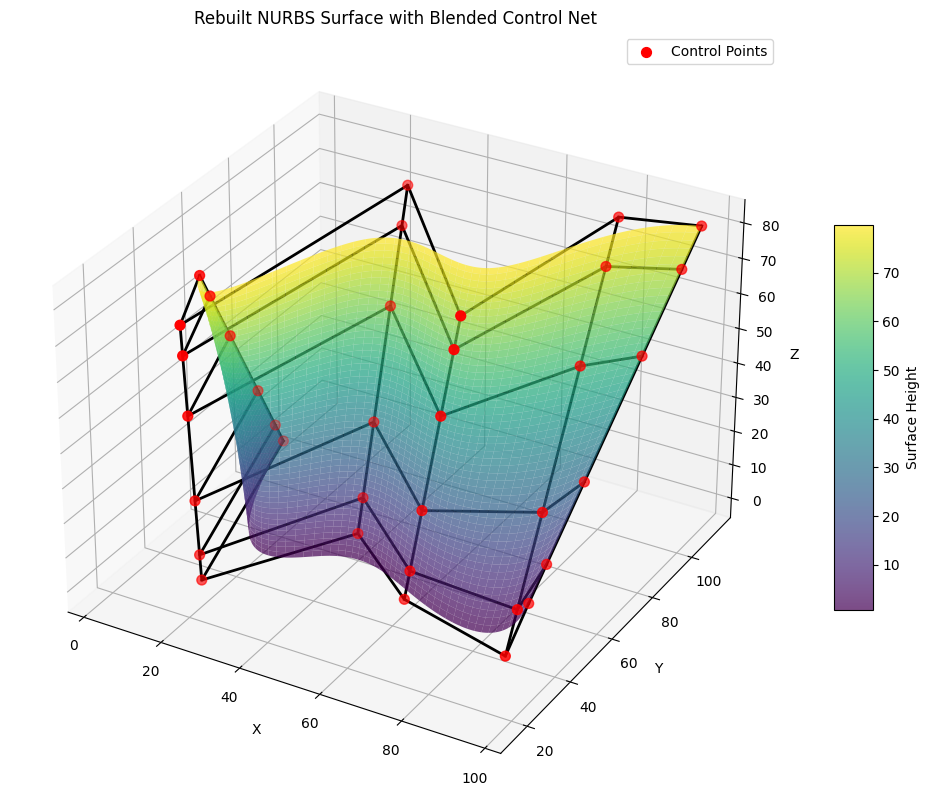

In [52]:
# Assume that earlier in your workflow you obtained a NURBS surface "nurbs_surf"
# from the interpolated surface, for example via:
# nurbs_surf = get_surface_control_net(surface_points, degree_u=3, degree_v=3, ctrlpts_size_u=10, ctrlpts_size_v=10)
#
# For the sake of example, we assume nurbs_surf is already defined.

# Rebuild the surface with uniform knot vectors
uniform_surf = rebuild_nurbs_surface_from_control_net(nurbs_surf)

# Visualize the rebuilt surface
visualize_nurbs_surface_with_control_net(uniform_surf, num_samples_u=500, num_samples_v=500)


# workflow cell

Curve 1 is at z = 0 and Curve 2 is at z = 74.18


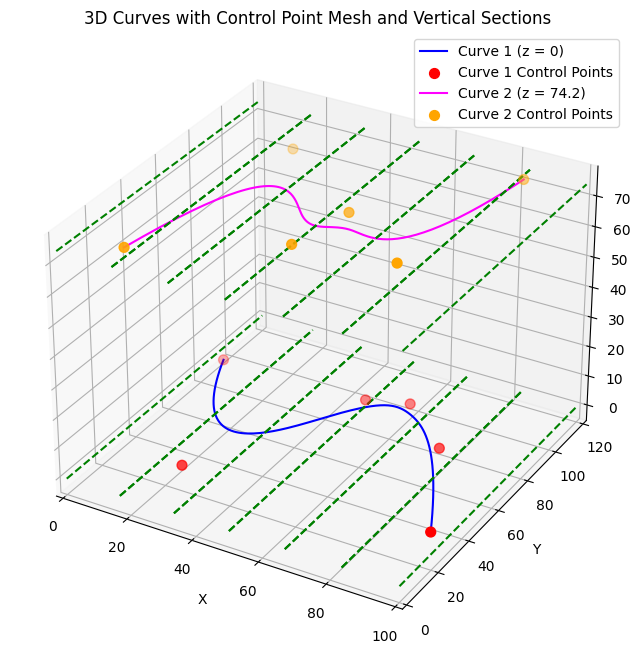

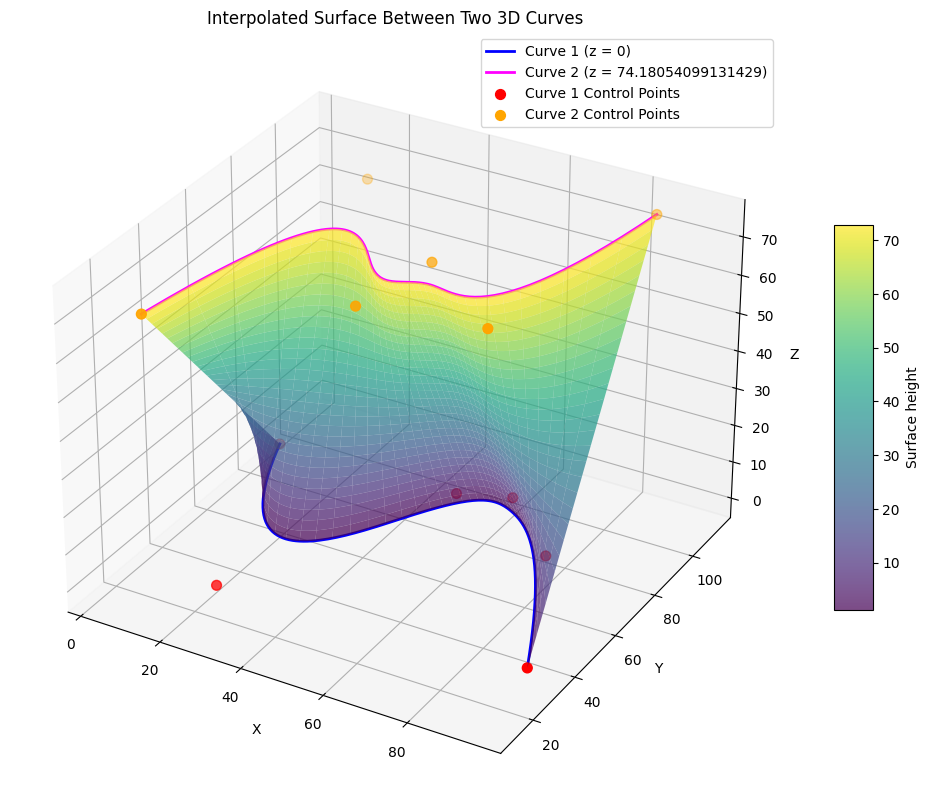

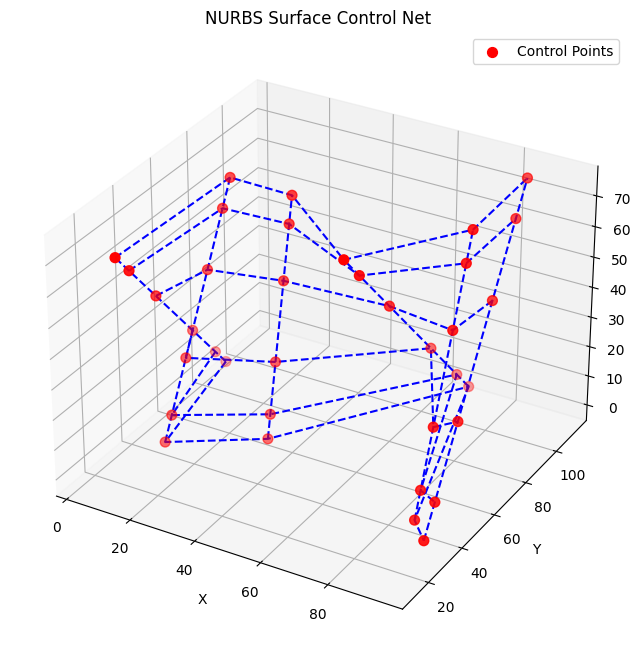

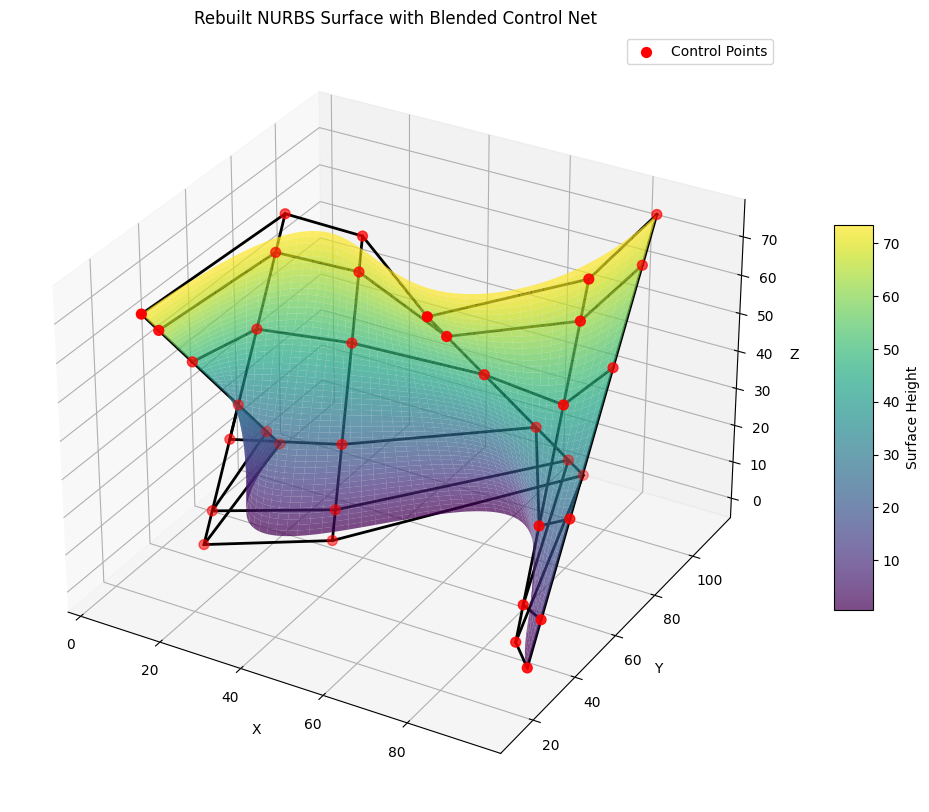

In [53]:
# --- Example: Generate, Interpolate, and Get the Surface Control Net ---

# Parameters for 2D curves.
num_curves = 100
num_points = 6
plane_width = 100
plane_height = 120
closed = False

# Generate 2D test data.
test_data = create_test_data_vertical_sections(num_curves, num_points, plane_width, plane_height, closed=closed)

# Select two curves (for example, indices 6 and 8).
curve2d_1 = test_data[6]  # (control_points, bspline, section_bounds)
curve2d_2 = test_data[8]

# Place the selected curves in 3D.
curve3d_1, curve3d_2, gap = place_curves_in_z(curve2d_1, curve2d_2)
print(f"Curve 1 is at z = 0 and Curve 2 is at z = {gap:.2f}")

# Visualize the 3D curves with control point meshes and vertical sections.
visualize_curves_3d(curve3d_1, curve3d_2, plane_width, plane_height, num_samples=161)

# Interpolate a surface between the two 3D curves.
surface_points = interpolate_surface_between_curves(curve3d_1, curve3d_2, num_u=161, num_v=30)

# Visualize the interpolated surface.
visualize_surface_3d(surface_points, curve1_3d=curve3d_1, curve2_3d=curve3d_2, show_control_points=True)

# --- Now use geomdl to approximate a NURBS surface from the interpolated data ---
# Adjust the desired control net sizes as needed.
nurbs_surf = get_surface_control_net(surface_points, degree_u=3, degree_v=3, ctrlpts_size_u=6, ctrlpts_size_v=6)

# Visualize the control net of the approximated NURBS surface.
visualize_surface_control_net(nurbs_surf)

# Rebuild the surface with uniform knot vectors
uniform_surf = rebuild_nurbs_surface_from_control_net(nurbs_surf)

# Visualize the rebuilt surface
visualize_nurbs_surface_with_control_net(uniform_surf, num_samples_u=500, num_samples_v=500)

In [54]:
def sample_nurbs_surface_with_control_net(surf, num_samples_u=50, num_samples_v=50):
    """
    Uniformly sample a geomdl NURBS surface and extract its control point polygon.

    Args:
        surf (geomdl.NURBS.Surface): A NURBS surface object.
        num_samples_u (int): Number of sample points in the u-direction.
        num_samples_v (int): Number of sample points in the v-direction.

    Returns:
        tuple: A tuple (pts, control_net) where:
            pts (np.ndarray): An array of shape (num_samples_u, num_samples_v, 3)
                              containing the evaluated surface points.
            control_net (np.ndarray): An array of shape (size_u, size_v, 3) representing
                              the control point polygon of the surface.
    """
    import numpy as np

    # Determine valid parameter ranges from the knot vectors
    u_start = surf.knotvector_u[surf.degree_u]
    u_end = surf.knotvector_u[-(surf.degree_u + 1)]
    v_start = surf.knotvector_v[surf.degree_v]
    v_end = surf.knotvector_v[-(surf.degree_v + 1)]

    # Create uniform parameter grids
    u_vals = np.linspace(u_start, u_end, num_samples_u)
    v_vals = np.linspace(v_start, v_end, num_samples_v)

    # Evaluate the surface at each (u,v) pair
    pts = np.empty((num_samples_u, num_samples_v, 3))
    for i, u in enumerate(u_vals):
        for j, v in enumerate(v_vals):
            pts[i, j, :] = surf.evaluate_single([u, v])

    # Extract control point polygon
    try:
        size_u, size_v = surf.ctrlpts_size
    except TypeError:
        size_u = surf.ctrlpts_size_u
        size_v = surf.ctrlpts_size_v

    control_net = np.array(surf.ctrlpts).reshape((size_u, size_v, 3))

    return pts, control_net



def visualize_sampled_surface_and_control_net(surf, num_samples_u=50, num_samples_v=50):
    """
    Uniformly sample a geomdl NURBS surface and visualize the resulting grid of points
    along with the control point polygon (control net) overlaid.

    Args:
        surf (geomdl.NURBS.Surface): The NURBS surface to sample.
        num_samples_u (int): Number of sample points in the u-direction.
        num_samples_v (int): Number of sample points in the v-direction.

    This function uses the sample_nurbs_surface_with_control_net routine to get both the
    evaluated surface points and the control net, then plots them in a 3D scatter/line plot.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    # Sample the surface and extract the control net
    pts, control_net = sample_nurbs_surface_with_control_net(surf, num_samples_u, num_samples_v)

    # Create a 3D figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the sampled surface points (flattening the grid for scatter plotting)
    pts_flat = pts.reshape(-1, 3)
    ax.scatter(pts_flat[:, 0], pts_flat[:, 1], pts_flat[:, 2],
               color='magenta', s=20, label="Sampled Surface Points")

    # Extract control net dimensions
    size_u, size_v, _ = control_net.shape

    # Plot the control net points
    ax.scatter(control_net[:, :, 0], control_net[:, :, 1], control_net[:, :, 2],
               color='red', s=50, label="Control Net Points")

    # Connect control points along u-direction (rows)
    for i in range(size_u):
        ax.plot(control_net[i, :, 0], control_net[i, :, 1], control_net[i, :, 2],
                color='black', linestyle='--', linewidth=2, label="Control Net" if i == 0 else "")

    # Connect control points along v-direction (columns)
    for j in range(size_v):
        ax.plot(control_net[:, j, 0], control_net[:, j, 1], control_net[:, j, 2],
                color='black', linestyle='--', linewidth=2)

    ax.set_title("Sampled NURBS Surface and Control Net")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()


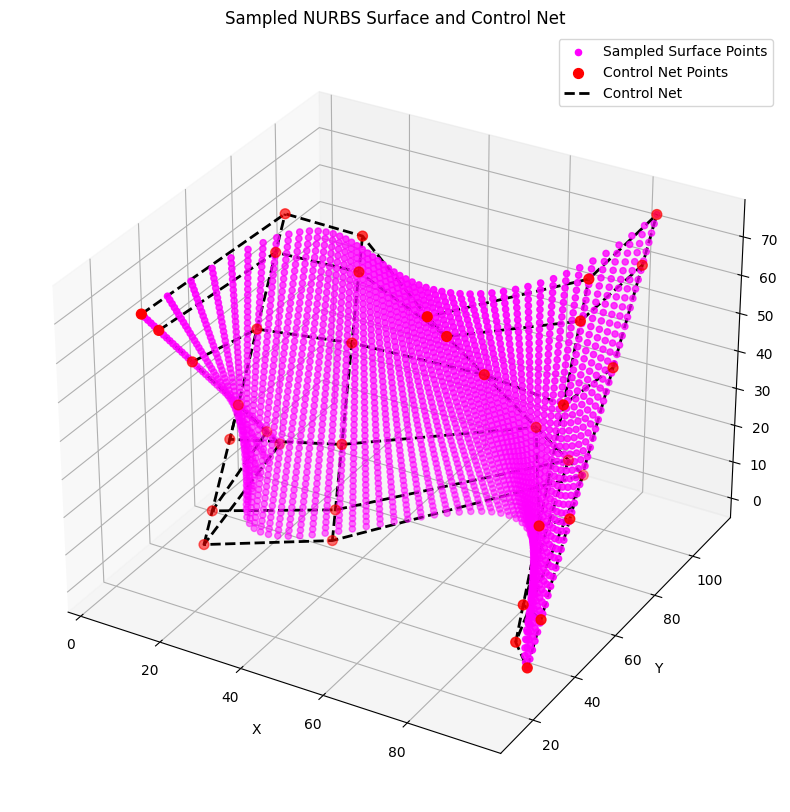

In [55]:
visualize_sampled_surface_and_control_net(uniform_surf, num_samples_u=50, num_samples_v=50)



In [56]:
def add_gaussian_noise(points, noise_std=0.1):
    """
    Add Gaussian noise to a set of points.

    Args:
        points (np.ndarray): An array of points (can be of any shape, e.g., (n, 3) or (num_u, num_v, 3)).
        noise_std (float): The standard deviation of the Gaussian noise.

    Returns:
        np.ndarray: The noisy points, with the same shape as the input.
    """
    import numpy as np
    noise = np.random.normal(loc=0, scale=noise_std, size=points.shape)
    return points + noise




def visualize_noisy_sampled_surface_and_control_net(surf, noise_std=0.05, num_samples_u=50, num_samples_v=50):
    """
    Uniformly sample a geomdl NURBS surface, add Gaussian noise to the samples,
    and visualize both the noisy surface points and the control net (control point polygon).

    Args:
        surf (geomdl.NURBS.Surface): The NURBS surface to sample.
        noise_std (float): Standard deviation for the Gaussian noise.
        num_samples_u (int): Number of sample points in the u-direction.
        num_samples_v (int): Number of sample points in the v-direction.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    # First, sample the surface and extract the control net.
    pts, control_net = sample_nurbs_surface_with_control_net(surf, num_samples_u, num_samples_v)

    # Add Gaussian noise to the sampled points.
    noisy_pts = pts + np.random.normal(loc=0, scale=noise_std, size=pts.shape)

    # Create a 3D plot.
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the noisy surface points.
    pts_flat = noisy_pts.reshape(-1, 3)
    ax.scatter(pts_flat[:, 0], pts_flat[:, 1], pts_flat[:, 2],
               color='magenta', s=20, label="Noisy Surface Points")

    # Plot the control net points.
    size_u, size_v, _ = control_net.shape
    ax.scatter(control_net[:, :, 0], control_net[:, :, 1], control_net[:, :, 2],
               color='red', s=50, label="Control Net Points")

    # Connect control net points along u-direction (rows).
    for i in range(size_u):
        ax.plot(control_net[i, :, 0], control_net[i, :, 1], control_net[i, :, 2],
                color='black', linestyle='--', linewidth=2, label="Control Net" if i==0 else "")

    # Connect control net points along v-direction (columns).
    for j in range(size_v):
        ax.plot(control_net[:, j, 0], control_net[:, j, 1], control_net[:, j, 2],
                color='black', linestyle='--', linewidth=2)

    ax.set_title("Noisy Sampled NURBS Surface and Control Net")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()



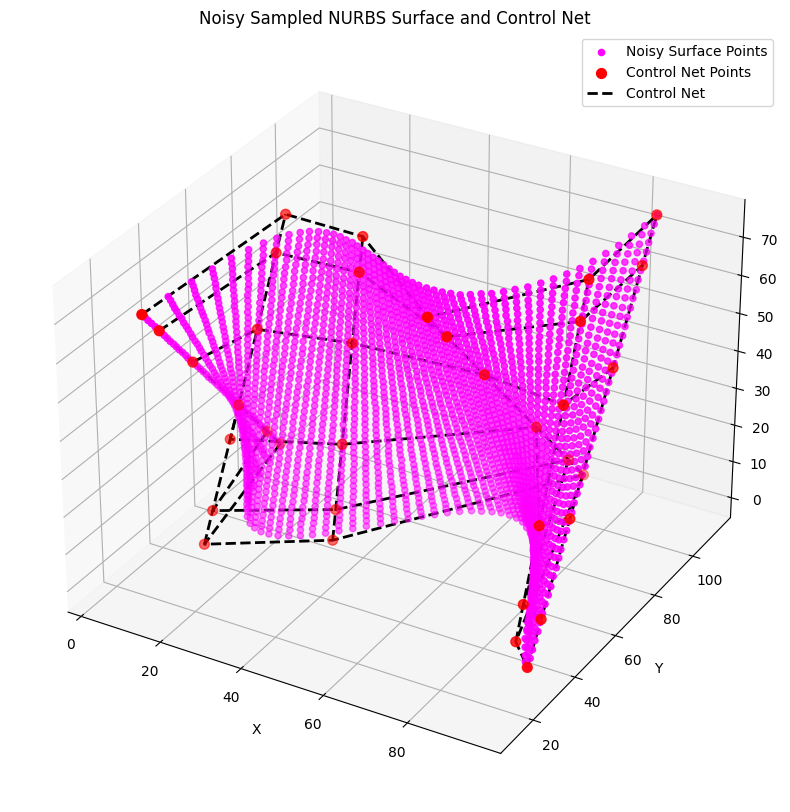

In [57]:
visualize_noisy_sampled_surface_and_control_net(uniform_surf, noise_std=0.05, num_samples_u=50, num_samples_v=50)



In [58]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

def random_rotation_matrix():
    """
    Generate a random 3D rotation matrix using a random axis-angle representation.
    """
    axis = np.random.randn(3)
    axis = axis / np.linalg.norm(axis)
    angle = np.random.uniform(0, 2 * np.pi)
    # Rodrigues' rotation formula
    K = np.array([[0, -axis[2], axis[1]],
                  [axis[2], 0, -axis[0]],
                  [-axis[1], axis[0], 0]])
    R = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * (K @ K)
    return R

def rotate_points(points, R, center):
    """
    Rotate points around a center using the given rotation matrix.

    Args:
        points (np.ndarray): Array of points (any shape ending in 3).
        R (np.ndarray): A 3x3 rotation matrix.
        center (np.ndarray): A 3-element array representing the center of rotation.

    Returns:
        np.ndarray: The rotated points, same shape as input.
    """
    return np.dot((points - center), R.T) + center

def rotate_surface_randomly(pts, control_net):
    """
    Randomly rotate the surface (sampled points and control net) around its center.

    Args:
        pts (np.ndarray): Sampled surface points, shape (num_samples_u, num_samples_v, 3)
        control_net (np.ndarray): Control net points, shape (size_u, size_v, 3)

    Returns:
        tuple: (rotated_pts, rotated_control_net)
    """
    # Compute the center of the surface (using the sampled points)
    center = pts.reshape(-1, 3).mean(axis=0)
    R = random_rotation_matrix()
    rotated_pts = rotate_points(pts, R, center)
    rotated_control_net = rotate_points(control_net, R, center)
    return rotated_pts, rotated_control_net

def visualize_rotated_surface_and_control_net(surf, num_samples_u=50, num_samples_v=50):
    """
    Sample a NURBS surface, randomly rotate it around its center, and visualize the rotated
    surface points and its control net in 3D.

    Args:
        surf (geomdl.NURBS.Surface): The NURBS surface object.
        num_samples_u (int): Number of sample points in the u-direction.
        num_samples_v (int): Number of sample points in the v-direction.
    """
    # Assume the function sample_nurbs_surface_with_control_net is defined and returns:
    # (pts, control_net) where pts is (num_samples_u, num_samples_v, 3) and control_net is (size_u, size_v, 3)
    pts, control_net = sample_nurbs_surface_with_control_net(surf, num_samples_u, num_samples_v)

    # Rotate the surface and control net randomly around the surface center.
    rotated_pts, rotated_control_net = rotate_surface_randomly(pts, control_net)

    # Visualization
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the rotated sampled surface points
    pts_flat = rotated_pts.reshape(-1, 3)
    ax.scatter(pts_flat[:, 0], pts_flat[:, 1], pts_flat[:, 2],
               color='magenta', s=20, label='Rotated Surface Points')

    # Plot the rotated control net
    try:
        size_u, size_v = rotated_control_net.shape[:2]
    except Exception:
        size_u = surf.ctrlpts_size_u
        size_v = surf.ctrlpts_size_v
    ax.scatter(rotated_control_net[:, :, 0], rotated_control_net[:, :, 1], rotated_control_net[:, :, 2],
               color='red', s=50, label='Rotated Control Net Points')

    # Connect control net points along u-direction (rows)
    for i in range(size_u):
        ax.plot(rotated_control_net[i, :, 0], rotated_control_net[i, :, 1], rotated_control_net[i, :, 2],
                color='black', linestyle='--', linewidth=2, label='Control Net' if i == 0 else "")

    # Connect control net points along v-direction (columns)
    for j in range(size_v):
        ax.plot(rotated_control_net[:, j, 0], rotated_control_net[:, j, 1], rotated_control_net[:, j, 2],
                color='black', linestyle='--', linewidth=2)

    ax.set_title("Randomly Rotated Surface and Control Net")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()


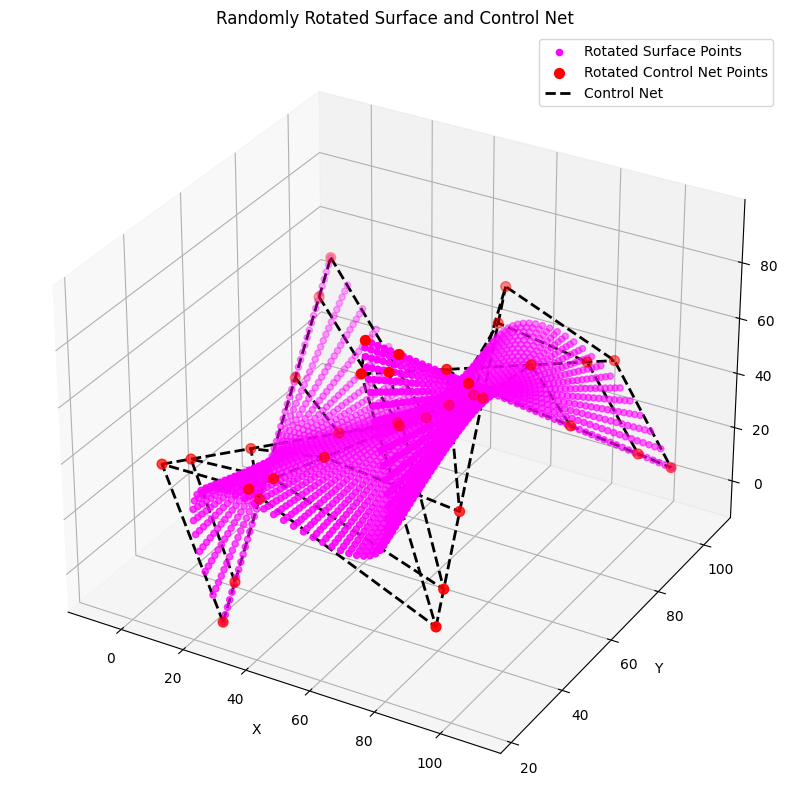

In [59]:
pts, control_net = sample_nurbs_surface_with_control_net(surf, num_samples_u, num_samples_v)

# Rotate the surface and control net randomly around the surface center.
rotated_pts, rotated_control_net = rotate_surface_randomly(pts, control_net)

visualize_rotated_surface_and_control_net(uniform_surf, num_samples_u=50, num_samples_v=50)
